## Load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
pd.set_option('display.float_format', lambda x: '%.3f' % x)

SEED = 1234
SPLIT_SIZE = 0.80
target = ['churn']
data_file = r'C:\Users\Eric\Documents\___Portfolio\bcg-churn\data\df_merged.parquet'

## Split

In [2]:

def load_data(file_path):
    return pd.read_parquet(file_path)

def split_data(df, target, split_size, seed):
    train, test = train_test_split(df, train_size=split_size, random_state=seed, stratify=df[target])
    return train.reset_index(drop=True), test.reset_index(drop=True)

def save_data(df, file_path):
    df.to_parquet(file_path)

# Load data
df = load_data(data_file)

# Split data
train, test = split_data(df, target, SPLIT_SIZE, SEED)

# Reset index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Organize features

### Columns to drop

- `id`: Not useful for prediction.
- datetime columns: The raw datetime format does not provide any value for prediction.
- Any columns related to `price_*_3_*`: 60% of the counts represent 0 prices, which was not significant when measuring price elasticity of demand.
- `margin_gross_pow_ele`: Redundant since we already have `margin_net_pow_ele`.
- price_zero columns:  

In [3]:
drop_cols = ['id', 'margin_gross_pow_ele', 'date_activ', 'date_end', 'date_modif_prod', 'date_renewal','price_e_3_diff_dec_jan', 'price_p_3_diff_dec_jan', 'price_e_3_mean',
       'price_e_3_std', 'price_p_3_mean', 'price_p_3_std', 'price_e_1_zero', 'price_e_2_zero', 'price_e_3_zero', 'price_p_1_zero',
       'price_p_2_zero', 'price_p_3_zero']

bi_cols = ['has_gas']
int_cols = ['forecast_discount_energy', 'n_actv_ps', 'years_as_client']
cat_cols = ['sales_channel_id', 'first_ec_id']
num_cols = ['cons_12m',
 'cons_gas_12m',
 'cons_last_month',
 'forecast_cons_12m',
 'forecast_cons_year',
 'forecast_meter_rent_12m',
 'forecast_price_e_1',
 'forecast_price_e_2',
 'forecast_price_p_1',
 'imp_cons',
 'margin_net_pow_ele',
 'net_margin',
 'pow_max',
 'price_e_1_diff_dec_jan',
 'price_e_2_diff_dec_jan',
 'price_p_1_diff_dec_jan',
 'price_p_2_diff_dec_jan',
 'price_e_1_mean',
 'price_e_1_std',
 'price_e_2_mean',
 'price_e_2_std',
 'price_p_1_mean',
 'price_p_1_std',
 'price_p_2_mean',
 'price_p_2_std']

### Split labels

In [4]:
X_train, y_train = train.drop(columns=target, axis=1), train[target]
X_test, y_test = test.drop(columns=target, axis=1), test[target]

In [5]:
#sel_cols = target+drop_cols+bi_cols+int_cols+cat_cols
#all_cols = train.columns.tolist()
#num_cols = [col for col in all_cols if col not in sel_cols]
#all_sell = target+drop_cols+bi_cols+int_cols+cat_cols+num_cols
#print(sorted(all_sell) == sorted(all_cols))

### Skewed

In [6]:
def find_skewed_features(df, skew_thresh=4):
    """
    Identify skewed numerical features in a DataFrame.
    
    Args:
    df (pandas.DataFrame): Input dataframe
    skew_thresh (float): Skewness threshold to consider a feature as skewed. Default is 4.
    
    Returns:
    list: List of skewed features
    """
    # Validate input
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    
    # Calculate skewness for all columns
    skewness = df.skew()
    
    # Filter out columns where skewness is more than the threshold and minimum value is non-negative
    skewed_feats = skewness[(skewness > skew_thresh) & (df.min() >= 0)].index.tolist()
    
    return skewed_feats

skewed_cols = find_skewed_features(train[num_cols])    
skewed_cols

['cons_12m',
 'cons_gas_12m',
 'cons_last_month',
 'forecast_cons_12m',
 'forecast_cons_year',
 'imp_cons',
 'margin_net_pow_ele',
 'net_margin',
 'pow_max',
 'price_e_1_std',
 'price_e_2_std',
 'price_p_1_std',
 'price_p_2_std']

## Basic pipeline
1. Drop columns in drop_cols
2. Imputing with mode on cat_cols
3. One hot encoding on cat_cols 
4. Min Max Scaler on num_cols

In [7]:
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin


# Define a custom transformer that applies Log1p transformation to specified columns
class SelectiveLog1pTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed.loc[:, self.columns] = np.log1p(X_transformed.loc[:, self.columns])
        return X_transformed


cat_pipe = make_pipeline(
   SimpleImputer(strategy='most_frequent'),
   OneHotEncoder(handle_unknown='ignore')
)

# Nothing
null_prep = make_column_transformer(
                        (cat_pipe, cat_cols),
                        ('drop', drop_cols),
                        remainder='passthrough',
                        verbose_feature_names_out=False

                         )

# Just scaler
sc_prep = make_column_transformer(
                        (cat_pipe, cat_cols),
                        ('drop', drop_cols),
                        (MinMaxScaler(), num_cols+int_cols),
                        remainder='passthrough',
                        verbose_feature_names_out=False

                         )

## Log1p + Scaler

num_pipe = make_pipeline(SelectiveLog1pTransformer(skewed_cols), MinMaxScaler())
log_prep = make_column_transformer(
                        (cat_pipe, cat_cols),
                        ('drop', drop_cols),
                        (num_pipe, num_cols+int_cols),
                        remainder='passthrough',
                        verbose_feature_names_out=False
                         )                         

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

def evaluate_models(models, X_train, y_train, cv_splits=5, scoring_metrics=None, seed=None):
    if scoring_metrics is None:
        scoring_metrics = {
            'precision': make_scorer(precision_score),
            'recall': make_scorer(recall_score),
            'f1': make_scorer(f1_score),
            'accuracy': make_scorer(accuracy_score),
            'roc_auc': make_scorer(roc_auc_score)
        }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed)

    results = []
    for model_name, pipeline, Model, model_params in models:
        try:
            model = make_pipeline(pipeline, Model(**model_params, random_state=seed))
            scores = cross_validate(model, X_train, y_train, scoring=scoring_metrics, cv=cv, n_jobs=-1)
            mean_scores = {metric: scores[f'test_{metric}'].mean() for metric in scoring_metrics}
            result = {'Classifier': model_name, **mean_scores}
            results.append(result)
        except Exception as e:
            print(f"Error evaluating classifier {model_name}: {e}")

    df_results = pd.DataFrame(results).round(3)
    return df_results


models = [
    ('Dummy Stratified', null_prep, DummyClassifier, {'strategy': 'stratified'}),    
    ('Random Forest', null_prep, RandomForestClassifier, {}),
    ('Logistic Regression', null_prep, LogisticRegression, {}),
    ('XGBoost', null_prep, xgb.XGBClassifier, {})
]
null_results = evaluate_models(models, X_train, y_train, seed=SEED)
null_results.sort_values(by='f1', ascending=False)

,Classifier,precision,recall,f1,accuracy,roc_auc
3,XGBoost,0.513,0.095,0.160,0.903,0.543
0,Dummy Stratified,0.095,0.094,0.094,0.824,0.499
1,Random Forest,0.775,0.038,0.072,0.906,0.518
2,Logistic Regression,0.083,0.010,0.017,0.900,0.503


In [17]:
from lightgbm import LGBMClassifier

pipelines = {
   'null':null_prep,
   'sc':sc_prep,
   'log_prep':log_prep,

}

model_definitions = [
    ('Random Forest', RandomForestClassifier, {}),
    ('Logistic Regression', LogisticRegression, {}),
    ('LightGBM', LGBMClassifier, {}),
    ('XGBoost', xgb.XGBClassifier, {})
]


results = []

for pipeline_name, pipeline in pipelines.items():
    for model_name, Model, model_params in model_definitions:
        model_full_name = f'{pipeline_name}_{model_name}'
        models = [(model_full_name, pipeline, Model, model_params)]
        model_results = evaluate_models(models, X_train, y_train, seed=SEED)
        results.append(model_results)

# combine all dataframes
results_df = pd.concat(results)
results_df.sort_values(by='f1', ascending=False)

,Classifier,precision,recall,f1,accuracy,roc_auc
0,null_XGBoost,0.513,0.095,0.160,0.903,0.543
0,sc_XGBoost,0.489,0.089,0.150,0.903,0.540
0,log_prep_XGBoost,0.456,0.088,0.148,0.901,0.538
0,log_prep_LightGBM,0.587,0.059,0.107,0.904,0.527
0,sc_LightGBM,0.578,0.056,0.101,0.904,0.525
0,null_LightGBM,0.571,0.053,0.096,0.904,0.524
0,null_Random Forest,0.775,0.038,0.072,0.906,0.518
0,sc_Random Forest,0.733,0.038,0.072,0.905,0.518
0,log_prep_Random Forest,0.796,0.035,0.067,0.905,0.517
0,null_Logistic Regression,0.083,0.010,0.017,0.900,0.503


In [ ]:
'sales_channel_id','n_actv_ps','years_as_client','first_ec_id'

In [19]:
X_train.columns

Index(['id', 'sales_channel_id', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_e_1', 'forecast_price_e_2',
       'forecast_price_p_1', 'has_gas', 'imp_cons', 'margin_gross_pow_ele',
       'margin_net_pow_ele', 'n_actv_ps', 'net_margin', 'years_as_client',
       'first_ec_id', 'pow_max', 'price_e_1_diff_dec_jan',
       'price_e_2_diff_dec_jan', 'price_e_3_diff_dec_jan',
       'price_p_1_diff_dec_jan', 'price_p_2_diff_dec_jan',
       'price_p_3_diff_dec_jan', 'price_e_1_mean', 'price_e_1_std',
       'price_e_2_mean', 'price_e_2_std', 'price_e_3_mean', 'price_e_3_std',
       'price_p_1_mean', 'price_p_1_std', 'price_p_2_mean', 'price_p_2_std',
       'price_p_3_mean', 'price_p_3_std', 'price_e_1_zero', 'price_e_2_zero',
       'price_e_3_zero', 'price_p_1_zero', 'price_p_2_zero', 'price_

### Evaluate models with SMOTE

In [243]:
from imblearn.pipeline import make_pipeline as imb_pipe
# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto')

models = [
    ('Dummy Stratified', null_prep, SMOTE(sampling_strategy='auto'), DummyClassifier, {'strategy': 'stratified'}),    
    ('Random Forest', null_prep, SMOTE(sampling_strategy='auto'), RandomForestClassifier, {}),
    ('Logistic Regression',SMOTE(sampling_strategy='auto'), null_prep, LogisticRegression, {}),
    ('XGBoost', SMOTE(sampling_strategy='auto'),null_prep, xgb.XGBClassifier, {})
]

imb_pipe = imb_pipe(null_prep, smote, model)
    
#sm_null_results = evaluate_models(models, X_train, y_train, seed=SEED)
#sm_null_results.sort_values(by='f1', ascending=False)

In [248]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate
from imblearn.pipeline import make_pipeline as imb_pipe
from imblearn.over_sampling import SMOTE
import pandas as pd

# assuming null_prep, sc_prep, log_prep are defined preprocessing steps
pipelines = {
   'null':null_prep,
   'sc':sc_prep,
   'log_prep':log_prep,
}

model_definitions = [
    ('Dummy Stratified', DummyClassifier, {'strategy': 'stratified'}),    
    ('Random Forest', RandomForestClassifier, {}),
    ('Logistic Regression', LogisticRegression, {}),
    ('XGBoost', XGBClassifier, {}),
    ('LightGBM', LGBMClassifier, {})
]

# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto')

results = []

# Cross-validation metrics
scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy', 'roc_auc']

for pipeline_name, pipeline in pipelines.items():
    for model_name, Model, model_params in model_definitions:
        # Create a pipeline: preprocessing, SMOTE, model
        model_pipeline = imb_pipe(pipeline, smote, Model(**model_params))
        
        # Perform cross-validation
        scores = cross_validate(model_pipeline, X_train, y_train, cv=5, scoring=scoring)

        # Store results
        results.append({
            'Classifier': f'{pipeline_name}_{model_name}',
            'precision': np.mean(scores['test_precision_macro']),
            'recall': np.mean(scores['test_recall_macro']),
            'f1': np.mean(scores['test_f1_macro']),
            'accuracy': np.mean(scores['test_accuracy']),
            'roc_auc': np.mean(scores['test_roc_auc'])
        })

# convert results into DataFrame
results_df = pd.DataFrame(results)

# sort by F1 score
results_df.sort_values(by='f1', ascending=False, inplace=True)

print(results_df)


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\imblearn\pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\imblearn\pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\imblearn\pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\imblearn\pipeline.py:272: DataConversionWarning: 

[13:02:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[13:02:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[13:02:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[13:02:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[13:02:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 

[13:03:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[13:03:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[13:03:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[13:03:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[13:04:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 

[13:04:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[13:05:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[13:05:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[13:05:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[13:05:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 

                      Classifier  precision  recall    f1  accuracy  roc_auc
8                     sc_XGBoost      0.634   0.560 0.576     0.890    0.673
9                    sc_LightGBM      0.626   0.556 0.570     0.890    0.675
13              log_prep_XGBoost      0.643   0.553 0.567     0.895    0.677
11        log_prep_Random Forest      0.656   0.552 0.567     0.897    0.670
6               sc_Random Forest      0.630   0.549 0.563     0.892    0.668
14             log_prep_LightGBM      0.645   0.546 0.559     0.895    0.676
3                   null_XGBoost      0.670   0.543 0.555     0.900    0.681
4                  null_LightGBM      0.711   0.537 0.545     0.903    0.687
1             null_Random Forest      0.702   0.533 0.538     0.903    0.671
12  log_prep_Logistic Regression      0.538   0.606 0.476     0.593    0.642
7         sc_Logistic Regression      0.536   0.603 0.470     0.583    0.643
10     log_prep_Dummy Stratified      0.506   0.518 0.409     0.504    0.507

In [9]:
from sklearn.metrics import classification_report

xgb_baseline = imb_pipe(sc_prep, smote, XGBClassifier(random_state=SEED))
xgb_baseline.fit(X_train, y_train.values.ravel())
y_pred_xgb = xgb_baseline.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

NameError: name 'imb_pipe' is not defined

In [261]:
xgb_baseline = make_pipeline(null_prep, XGBClassifier(random_state=SEED, scale_pos_weight=8))
xgb_baseline.fit(X_train, y_train.values.ravel())
y_pred_xgb = xgb_baseline.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:17:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2638
           1       0.28      0.24      0.26       284

    accuracy                           0.87      2922
   macro avg       0.60      0.59      0.59      2922
weighted avg       0.86      0.87      0.86      2922



In [262]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

# select sampler
sm = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'), random_state=SEED)
xgb_baseline = imb_pipe(null_prep, sm, XGBClassifier(random_state=SEED))
xgb_baseline.fit(X_train, y_train.values.ravel())
y_pred_xgb = xgb_baseline.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:18:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2638
           1       0.30      0.22      0.25       284

    accuracy                           0.87      2922
   macro avg       0.61      0.58      0.59      2922
weighted avg       0.86      0.87      0.86      2922



In [260]:
xgb_baseline = imb_pipe(null_prep, smote, XGBClassifier(random_state=SEED))
xgb_baseline.fit(X_train, y_train.values.ravel())
y_pred_xgb = xgb_baseline.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:17:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2638
           1       0.58      0.14      0.22       284

    accuracy                           0.91      2922
   macro avg       0.75      0.56      0.59      2922
weighted avg       0.88      0.91      0.88      2922



In [ ]:
xgb_baseline = make_pipeline(sc_prep, XGBClassifier(random_state=SEED))
xgb_baseline.fit(X_train, y_train.values.ravel())
y_pred_xgb = xgb_baseline.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

In [263]:
xgb_baseline = make_pipeline(log_prep, XGBClassifier(random_state=SEED, scale_pos_weight=8))
xgb_baseline.fit(X_train, y_train.values.ravel())
y_pred_xgb = xgb_baseline.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:53:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2638
           1       0.29      0.25      0.27       284

    accuracy                           0.87      2922
   macro avg       0.61      0.59      0.60      2922
weighted avg       0.86      0.87      0.86      2922



In [259]:
xgb_baseline = make_pipeline(sc_prep, XGBClassifier(random_state=SEED, scale_pos_weight=8))
xgb_baseline.fit(X_train, y_train.values.ravel())
y_pred_xgb = xgb_baseline.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

c:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:15:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2638
           1       0.27      0.23      0.25       284

    accuracy                           0.86      2922
   macro avg       0.59      0.58      0.59      2922
weighted avg       0.85      0.86      0.86      2922



## FE with Leave One Feature Out (LOFO) 

In [215]:
def get_X_transformed(pipeline, X_train, X_test, y_train):
    X_train_t, X_test_t = pipeline.fit_transform(X_train, y_train), pipeline.transform(X_test)
    X_train_t = pd.DataFrame(X_train_t, columns=pipeline.get_feature_names_out())
    X_test_t = pd.DataFrame(X_test_t, columns=pipeline.get_feature_names_out())
    return X_train_t, X_test_t


cols_to_drop = ['id',
 'margin_gross_pow_ele',
 'date_activ',
 'date_end',
 'date_modif_prod',
 'date_renewal']

# Nothing
ohe_prep = make_column_transformer(
                        (cat_pipe, cat_cols),
                        ('drop', cols_to_drop),
                        remainder='passthrough',
                        verbose_feature_names_out=False

                         )



X_train_ohe, X_test_ohe = get_X_transformed(ohe_prep, X_train, X_test, y_train) 
train_ohe = pd.concat([X_train_ohe, y_train], axis=1)   
train_ohe.head(4)

,sales_channel_id_a,sales_channel_id_b,sales_channel_id_c,sales_channel_id_d,sales_channel_id_e,sales_channel_id_f,sales_channel_id_g,first_ec_id_a,first_ec_id_b,first_ec_id_c,...,price_p_2_std,price_p_3_mean,price_p_3_std,price_e_1_zero,price_e_2_zero,price_e_3_zero,price_p_1_zero,price_p_2_zero,price_p_3_zero,churn
0,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,16.226,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
1,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,1.000,0
2,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,1.000,0
3,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,1.000,0


100%|██████████| 52/52 [03:06<00:00,  3.59s/it]


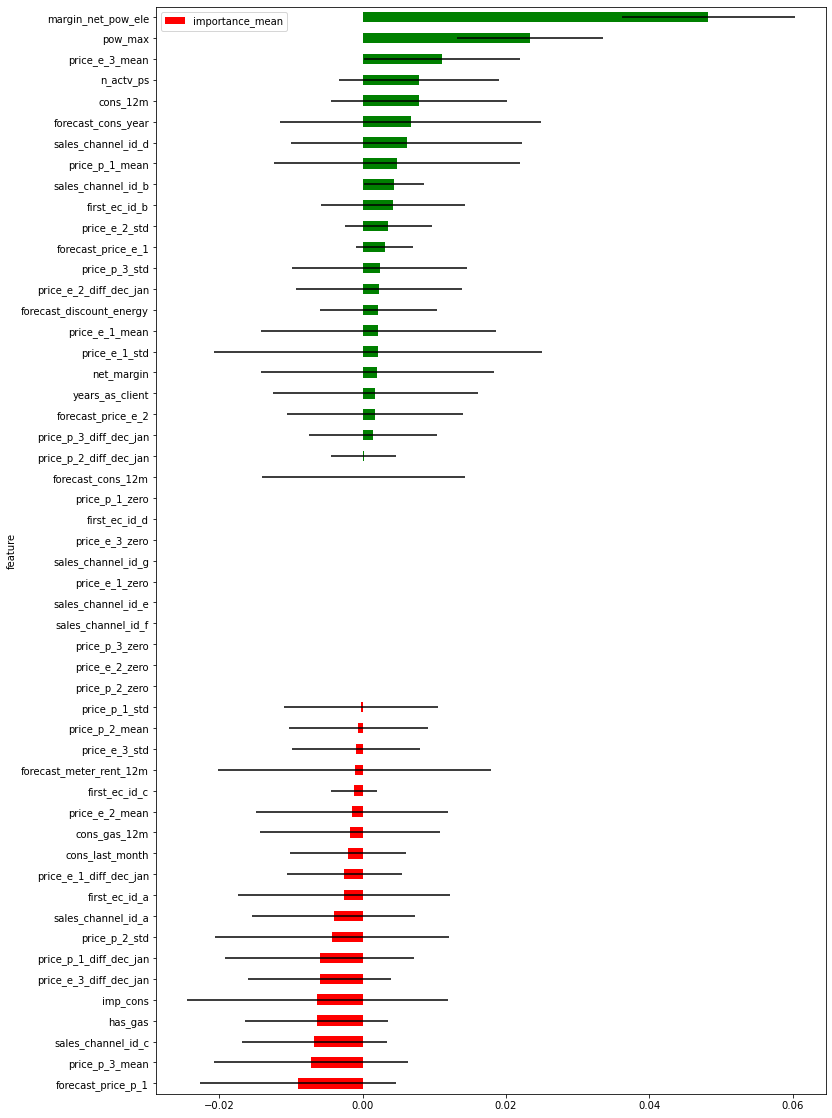

In [216]:
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.model_selection import KFold
# define the validation scheme
cv = KFold(n_splits=5, shuffle=False, random_state=None) # Don't shuffle to keep the time split split validation

# define the binary target and the features
dataset = Dataset(df=train_ohe, target="churn", features=[col for col in train_ohe.columns if col != "churn"])

# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="f1")


# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20))

In [237]:
not_important_cols = importance_df[importance_df.importance_mean < 0]['feature'].unique().tolist()
important_cols = importance_df[importance_df.importance_mean > 0]['feature'].unique().tolist()

In [13]:
drop_cols_2 = ['id',
 'cons_gas_12m',
 'cons_last_month',
'price_p_2_std',
 'price_p_1_diff_dec_jan',
 'price_e_3_diff_dec_jan',
'forecast_price_p_1',
'imp_cons',
'has_gas',
'forecast_meter_rent_12m',
 'margin_gross_pow_ele',
 'date_activ',
 'date_end',
 'date_modif_prod',
 'date_renewal',
 'price_e_3_mean',
 'price_e_3_std',
 'price_p_3_mean',
 'price_p_3_std',
 'price_e_1_zero',
 'price_e_2_zero',
 'price_e_3_zero',
 'price_p_1_zero',
 'price_p_2_zero',
 'price_p_3_zero']

In [15]:
# Just scaler
sc_prep = make_column_transformer(
                        (cat_pipe, cat_cols),
                        ('drop', drop_cols_2),
                        (MinMaxScaler(), num_cols+int_cols),
                        remainder='passthrough',
                        verbose_feature_names_out=False

                         )

## Log1p + Scaler



In [16]:
null_prep_new

NameError: name 'null_prep_new' is not defined

In [12]:
num_columns = X_train.drop(columns=drop_cols_2).select_dtypes(include=['number']).columns.tolist()
skewed_cols_2 = find_skewed_features(train[num_columns])  
from sklearn.preprocessing import PolynomialFeatures
sc_prep_new = make_column_transformer(
                        (cat_pipe, cat_cols),
                        ('drop', drop_cols_2),
                        (MinMaxScaler(), num_columns),
                        remainder='passthrough',
                        verbose_feature_names_out=False

                         )

num_pipe = make_pipeline(SelectiveLog1pTransformer(skewed_cols_2), MinMaxScaler())
log_prep_new = make_column_transformer(
                        (cat_pipe, cat_cols),
                        ('drop', drop_cols),
                        (num_pipe, num_columns),
                        remainder='passthrough',
                        verbose_feature_names_out=False
                         )                         

pipelines = {
   'null':null_prep_new,
   'sc':sc_prep_new,
   'log':log_prep_new
}

model_definitions = [
    ('Random Forest', RandomForestClassifier, {}),
    ('Logistic Regression', LogisticRegression, {}),
    ('LightGBM', LGBMClassifier, {}),
    ('XGBoost', xgb.XGBClassifier, {})
]


results = []

for pipeline_name, pipeline in pipelines.items():
    for model_name, Model, model_params in model_definitions:
        model_full_name = f'{pipeline_name}_{model_name}'
        models = [(model_full_name, pipeline, Model, model_params)]
        model_results = evaluate_models(models, X_train, y_train, seed=SEED)
        results.append(model_results)

# combine all dataframes
results_df = pd.concat(results)
results_df.sort_values(by='f1', ascending=False)

NameError: name 'drop_cols_2' is not defined

In [377]:
from sklearn.preprocessing import PolynomialFeatures
rf_baseline = make_pipeline(null_prep, PolynomialFeatures(), RandomForestClassifier(random_state=SEED))
rf_baseline.fit(X_train, y_train.values.ravel())
y_pred_rf = rf_baseline.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2638
           1       0.82      0.06      0.12       284

    accuracy                           0.91      2922
   macro avg       0.86      0.53      0.53      2922
weighted avg       0.90      0.91      0.87      2922



In [295]:
rf_baseline = imb_pipe(sc_prep, sm, RandomForestClassifier(random_state=SEED))
#rf_baseline = make_pipeline(null_prep_new, RandomForestClassifier(random_state=SEED))
rf_baseline.fit(X_train, y_train.values.ravel())
y_pred_rf = rf_baseline.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2638
           1       0.21      0.29      0.24       284

    accuracy                           0.82      2922
   macro avg       0.56      0.58      0.57      2922
weighted avg       0.85      0.82      0.84      2922



In [287]:
rf_baseline = imb_pipe(sc_prep, sm, RandomForestClassifier(random_state=SEED))
#rf_baseline = make_pipeline(null_prep_new, RandomForestClassifier(random_state=SEED))
rf_baseline.fit(X_train, y_train.values.ravel())
y_pred_rf = rf_baseline.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2638
           1       0.21      0.29      0.24       284

    accuracy                           0.82      2922
   macro avg       0.56      0.58      0.57      2922
weighted avg       0.85      0.82      0.84      2922



In [286]:
rf_baseline = imb_pipe(sc_prep, smote, RandomForestClassifier(random_state=SEED))
#rf_baseline = make_pipeline(null_prep_new, RandomForestClassifier(random_state=SEED))
rf_baseline.fit(X_train, y_train.values.ravel())
y_pred_rf = rf_baseline.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2638
           1       0.36      0.14      0.20       284

    accuracy                           0.89      2922
   macro avg       0.64      0.56      0.57      2922
weighted avg       0.86      0.89      0.87      2922



In [299]:

rf_baseline = make_pipeline(null_prep_new, RandomForestClassifier(random_state=SEED))
rf_baseline.fit(X_train, y_train.values.ravel())
y_pred_rf = rf_baseline.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2638
           1       0.94      0.06      0.11       284

    accuracy                           0.91      2922
   macro avg       0.92      0.53      0.53      2922
weighted avg       0.91      0.91      0.87      2922



In [10]:
from sklearn.metrics import (accuracy_score, average_precision_score,
                             classification_report, confusion_matrix, f1_score,
                             precision_recall_curve, precision_score,
                             recall_score, silhouette_samples,
                             silhouette_score)

def threshold_predictions(proba, threshold):
    return (proba >= threshold).astype(int)

def plot_confusion_matrix(y_true, y_pred, labels=None, title='Confusion Matrix', cmap='Blues', fontsize=14):
    cm = confusion_matrix(y_true, y_pred)

    if labels is None:
        labels = [str(i) for i in range(len(cm))]

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, 
                     xticklabels=labels, yticklabels=labels, annot_kws={"size": fontsize, "ha": 'center', "va": 'center'})
    
    for t in ax.texts:
        t.set_text(t.get_text() + " ")  # Add a small space for better alignment
    
    plt.xlabel('Predicted', fontsize=fontsize)
    plt.ylabel('True', fontsize=fontsize)
    plt.title(title, fontsize=fontsize+2, pad=20)
    plt.show()

In [11]:

lgbm_baseline = make_pipeline(null_prep_new,PolynomialFeatures(), LGBMClassifier(random_state=SEED, class_weight='balanced', min_child_samples=int(0.01*X_train.shape[0])))
lgbm_baseline.fit(X_train, y_train.values.ravel())
y_pred_lgbm = lgbm_baseline.predict(X_test)
print(classification_report(y_test, y_pred_lgbm))

NameError: name 'null_prep_new' is not defined

In [364]:
y_proba = lgbm_baseline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find the threshold value where recall is closest to 0.8
target_recall = 0.8
idx = np.abs(recall - target_recall).argmin()
optimal_threshold = thresholds[idx]

print(f'Optimal threshold: {optimal_threshold:.4f}, Precision: {precision[idx]:.4f}, Recall: {recall[idx]:.4f}')

Optimal threshold: 0.2417, Precision: 0.1221, Recall: 0.7993


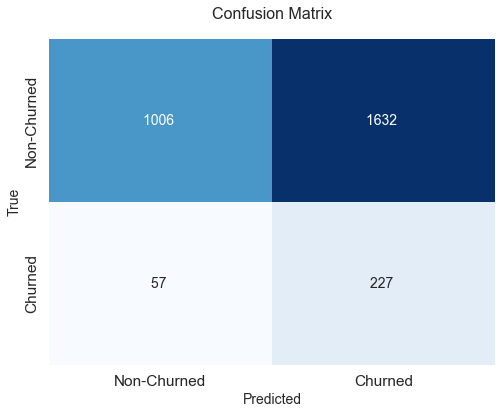

In [365]:
y_pred = threshold_predictions(y_proba, optimal_threshold)

plot_confusion_matrix(y_test, y_pred, labels=['Non-Churned', 'Churned'])

In [394]:
import joblib
# Save model
joblib.dump(lgbm_baseline, 'lgbm_baseline_model.pkl')

['lgbm_baseline_model.pkl']

In [368]:
lgbm_baseline = joblib.load('lgbm_baseline_model.pkl')